In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import scipy
from sklearn import preprocessing

2024-02-22 10:55:48.682063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 10:55:49.612389: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 10:55:49.612412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 10:55:49.615630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 10:55:50.124659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 10:55:50.126752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/swat_processed.csv", sep=",")

In [3]:
attacks = preprocessing.normalize(attacks.to_numpy(), norm="max", axis=0)

# swap sport to front
attacks[:, [0, 1]] = attacks[:, [1, 0]]
# swap dport to after sport
attacks[:, [1, 2]] = attacks[:, [2, 1]]
# swap protocols to after dport
attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)

# should probably add batch and shuffle

train_dataset = attacks[:int(np.floor(attacks.shape[0]*3/4))]
# test_dataset = attacks[int(np.floor(attacks.shape[0]*3/4)):]
test_dataset = attacks[:100000]

num_features = attacks[:int(np.floor(attacks.shape[0]*3/4))].shape[1]
seq_length = 5
latent_dim = 500

In [4]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.keras.backend.random_normal(tf.shape(log_var)) * tf.keras.backend.exp(log_var / 2) + mean

In [5]:
# encoder

inputs = tf.keras.layers.Input(shape=[num_features,1])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(z)
z = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(z)
codings_mean = tf.keras.layers.Dense(latent_dim)(z) # mu
codings_log_var = tf.keras.layers.Dense(latent_dim)(z) # gamma
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder

decoder_inputs = tf.keras.layers.Input(shape=[latent_dim])
x = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(num_features*1, activation="sigmoid")(x)
outputs = tf.keras.layers.Reshape([num_features, 1])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# VAE model

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

# VAE losses

latent_loss = -0.5 * tf.keras.backend.sum(1 + codings_log_var - tf.keras.backend.exp(codings_log_var) - tf.keras.backend.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.keras.backend.mean(latent_loss / float(num_features)))
# variational_ae.add_loss(tf.keras.backend.mean(latent_loss))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
variational_ae.compile(loss="binary_crossentropy", optimizer=optimizer)

In [6]:
def wasserstein_loss(y_pred, y_real):
    return tf.keras.backend.mean(y_pred * y_real)

def generator_wasserstein_loss(y_pred):
    return -tf.keras.backend.mean(y_pred)

class ClipConstraint(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value

In [7]:
def make_critic(input_shape):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.Flatten(input_shape=(input_shape[0]*input_shape[1])))
    # model.add(tf.keras.layers.LSTM(100, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm1"))
    # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm2"))
    model.add(tf.keras.layers.Dense(250, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const))

    model.add(tf.keras.layers.Dense(200, kernel_initializer=init, kernel_constraint=const))
    model.add(tf.keras.layers.Dropout(0.2))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.LeakyReLU(0.2))
    # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, name="c_lstm3"))
    model.add(tf.keras.layers.Dense(150, kernel_initializer=init, kernel_constraint=const))
    model.add(tf.keras.layers.Dropout(0.2))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Dense(100, kernel_initializer=init, kernel_constraint=const))
    model.add(tf.keras.layers.Dropout(0.2))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Dense(1, name="c_dense"))
    # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    # model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

def make_generator(output_shape, noise_dim):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.LSTM(100, input_shape=(5, output_shape), kernel_initializer=init, recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.Dense(100, input_shape=[noise_dim], kernel_initializer=init))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.LeakyReLU(0.2))
    # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, recurrent_dropout=0.4))
    model.add(tf.keras.layers.Dense(150, kernel_initializer=init))
    model.add(tf.keras.layers.Dropout(0.2))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Dense(200, kernel_initializer=init))
    model.add(tf.keras.layers.Dropout(0.2))
    tf.keras.layers.BatchNormalization()
    model.add(tf.keras.layers.LeakyReLU(0.2))
    # model.add(tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="tanh", kernel_initializer=init))
    # model.add(tf.keras.layers.Reshape([output_shape[0], output_shape[1]]))
    model.add(tf.keras.layers.Dense(output_shape, activation="sigmoid"))
    # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    # model.compile(loss=generator_wasserstein_loss, optimizer=opt)
    return model

def make_gan(generator, critic):
    model = tf.keras.models.Sequential()
    model.add(generator)
    model.add(critic)
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

## Step 1: Train autoencoder on real data

In [8]:
variational_ae.fit(train_dataset, train_dataset, epochs=15, batch_size=64)

Epoch 1/15
31151/31151 [==============================] - 43s 1ms/step - loss: 0.2511
Epoch 2/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2225
Epoch 3/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2186
Epoch 4/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2163
Epoch 5/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2152
Epoch 6/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2145
Epoch 7/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2140
Epoch 8/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2135
Epoch 9/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2130
Epoch 10/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2129
Epoch 11/15
31151/31151 [==============================] - 40s 1ms/step - loss: 0.2126
Epoch 12/15
31151/31151 [===========================

## Step 2: Train GAN to learn realistic latent vectors

In [9]:
generator_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.000005)
critic_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.000005)

def train_step(generator, critic, dataset, latent_dim, noise_dim, n_batch=40, n_critic=5):

    for _ in range(n_critic):

        """
        Train critic more often than the generator for WGAN
        """

        with tf.GradientTape() as critic_tape:
            ix = np.random.randint(0, dataset.shape[0], n_batch)
            # X_real = dataset.numpy()[ix]
            X_real = dataset[ix]
            noise = tf.random.normal((n_batch, noise_dim))
            X_fake = generator(noise, training=True)

            pred_real = critic(X_real, training=True)
            pred_fake = critic(X_fake, training=True)

            c_loss = wasserstein_loss(pred_real, pred_fake)
        

        critic_gradients = critic_tape.gradient(c_loss, critic.trainable_variables)
        critic_optimiser.apply_gradients(zip(critic_gradients, critic.trainable_variables))
    # print(f"Critic loss: {c_loss}")  
    
    """ 
    Train generator
    """

    with tf.GradientTape() as gen_tape:
        X_fake = generator(noise, training=True)
        pred_fake = critic(X_fake, training=True)
        g_loss = generator_wasserstein_loss(pred_fake)
        # print(f"Generator loss: {g_loss}")
    
    generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))


    return c_loss, g_loss

def train(dataset, n_epochs=2, noise_dim=50, latent_dim=50):

    generator = make_generator(latent_dim, noise_dim)
    critic = make_critic((latent_dim, 1))

    c_losses, g_losses = [], []

    for i in range(n_epochs):
        # print(f"Epoch: {i+1}")
        for batch in dataset:
            c_loss, g_loss = train_step(generator, critic, batch, latent_dim, noise_dim)
            c_losses.append(c_loss)
            g_losses.append(g_loss)
    
    noise = tf.random.normal((1000, noise_dim))
    prediction = generator.predict(noise)

    return c_losses, g_losses, prediction

In [10]:
real_latent_vectors = np.split((variational_encoder(attacks[:20000])[0]).numpy(), 200)
real_latent_vectors[0].shape

(100, 500)

In [11]:
len(real_latent_vectors)

200

In [12]:
c_losses, g_losses, pred = train(real_latent_vectors, 10, 30, latent_dim)

/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


32/32 [==============================] - 0s 822us/step


In [13]:

# noise_dim = 30
# n_batch = 64
# # create the critic
# critic = make_critic([latent_dim, 1])
# # create the generator
# # generator = make_generator((n_batch, latent_dim))
# generator = make_generator(latent_dim, noise_dim)
# # create the gan
# gan = make_gan(generator, critic)
# # load image data


# real_latent_vectors = variational_encoder(test_dataset)[0]
# epochs = 10
# # train model
# c1_loss, c2_loss, g_loss = train(generator, critic, gan, dataset=test_dataset[:10000], latent_dim=latent_dim, noise_dim=noise_dim, n_epochs=epochs, n_batch=n_batch)

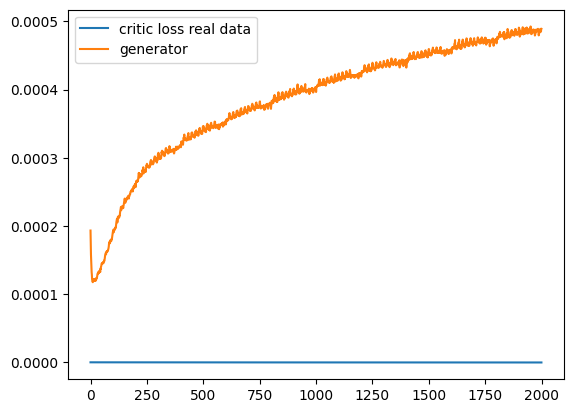

In [14]:
plt.plot(c_losses, label="critic loss real data")
plt.plot(g_losses, label="generator")
# plt.plot(c2_loss, label="critic loss fake data")
# plt.plot(g_loss, label="gen loss")
plt.legend()
plt.show()

## Step 3: Use generator to make latent vectors and decode with decoder

In [15]:
latent_vectors = pred
data = variational_decoder(latent_vectors)
scipy.stats.ks_2samp(test_dataset[:1000].reshape(23000,), data.numpy().reshape(23000,))
# data.numpy().shape, test_dataset.shape

KstestResult(statistic=0.7175217391304348, pvalue=0.0, statistic_location=0.002150400430080086, statistic_sign=1)

In [16]:
scipy.stats.wasserstein_distance(test_dataset[:1000].reshape(23000,), data.numpy().reshape(23000,))

0.10132390526996707

In [17]:
# from sklearn.neighbors import KernelDensity
# kde_gen = KernelDensity(kernel='epanechnikov').fit(data.numpy()[:, 10].reshape(-1, 1))
# kde_dat = KernelDensity(kernel='epanechnikov').fit(test_dataset[:1000, 10].reshape(-1, 1))

# plt.plot(kde_gen.score_samples(data.numpy()[:, 10].reshape(-1, 1)))

In [18]:
# plt.plot(kde_dat.score_samples(test_dataset[:1000, 10].reshape(-1, 1)))